In [1]:
import pandas as pd
import altair as alt 
import numpy as np
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
alt.data_transformers.enable('vegafusion')
set_config(transform_output="pandas")
np.random.seed(2000)

# Experience Level Detection Model

DSCI 100 Group 6 Final Project 

Abby Sun, Anas Ahmed, Michelle Wu, Youssef Abouelseoud

## Introduction

The Pacific Laboratory for Artificial Intelligence (PLAI) at UBC has launched an innovative project involving a new game called Plaicraft, described as a "free Minecraft in the cloud" (Smith, 2024). This initiative serves as a platform for gathering large-scale multiplayer gameplay data to train AI systems capable of exhibiting human-like behavior, aiming to replace traditional NPC bots and advance artificial general intelligence (AGI) research. The PLAI group aims to gather 10,000 hours of multiplayer gameplay data. Therefore, it is essential to recruit players who are likely to contribute significant amounts of gameplay time. 

This leads us to our research question: **Which kinds of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts?** To address this question, our team used a K-Nearest Neighbors (KNN) classification model to explore a more specific, predictive question: **What is a player’s experience level based on their age and the time they spend playing the game?** Understanding player experience levels can help inform recruitment strategies by identifying traits associated with high engagement.

For this project, we will be using data from players.csv, which is a list of all unique players with data about each player, collected by the PLAI group. This dataset has 9 columns and 196 observations organised as follows:

|Column Name|	Data Type|	Description|
|-----------|------------|------------------------------|
|experience	|Object| Cateorigical varaible; player’s experience level ('Pro', 'Veteran', 'Amateur', 'Regular', 'Beginner')|
|subscribe	|Boolean|Indicates if the player is subscribed to certain features or services.|
|hashedEmail|Object	|Unique hashed email for each player (used for identification)|
|played_hours|Float64|Total hours played by the player.	Contains values from 0 to 223.1|
|name	|Object	|Player’s name,	196 unique values|
|gender	|Object	|Player’s gender (e.g., Male, Female), has 7 unique values|
|age	|Int64|	Player’s age; range from 8 to 99|
|individualId	|Float64	|Unique identifier for each player; **no recorded values**|
|organizationName|	Float64	|Name of the organization the player is affiliated with, **no recorded values**|



## Methods & Results

### Method Overview: 

To answer our question, we will be using K-Nearest Neighbors (KNN) Classification to build 4 different models. Our two original predictor variables for the first model were: 

+ played_hours
+ age

and 3 other predictor variables were used later on in our analysis for feature engineering: 

+ squared_age
+ log_age
+ sin_age.

As for our response variable, we used the **experience level**, which has 5 different categories, 'Pro', 'Veteran', 'Amateur', 'Regular', and 'Beginner'. 

The four models are tested using accuracy and validated/examined using a confusion matrix.


### Import / Load Data

In [2]:
url = "https://docs.google.com/spreadsheets/d/"
sheetId = '1I3LWCl5-1ZsDIEe168lmFMKynXqypCO3UL7RogvcT34'
players = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheetId}/export?format=csv")
players.head()

,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
0,Pro,True,f6daba428a5e19a3d47574858c13550499be23603422e6...,30.3,Morgan,Male,9,NaN,NaN
1,Veteran,True,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa9397...,3.8,Christian,Male,17,NaN,NaN
2,Veteran,False,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3...,0.0,Blake,Male,17,NaN,NaN
3,Amateur,True,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4f...,0.7,Flora,Female,21,NaN,NaN
4,Regular,True,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb...,0.1,Kylie,Male,21,NaN,NaN


In [3]:
#data wrangling 

# add additional age columns for feature engineering
players_more = players.assign(squared_age = players['age']**2,
                              log_age = np.log(players['age']),
                              sin_age = np.sin(players['age']))

# select rows
players_wrangled = players_more[["played_hours", "age", "squared_age", "log_age", "sin_age", "experience"]]
players_wrangled.head()

,played_hours,age,squared_age,log_age,sin_age,experience
0,30.3,9,81,2.197225,0.412118,Pro
1,3.8,17,289,2.833213,-0.961397,Veteran
2,0.0,17,289,2.833213,-0.961397,Veteran
3,0.7,21,441,3.044522,0.836656,Amateur
4,0.1,21,441,3.044522,0.836656,Regular


### Summary statistics 

In [4]:
# the number of players in each experience category
players_wrangled['experience'].value_counts()

experience
Amateur     63
Veteran     48
Regular     36
Beginner    35
Pro         14
Name: count, dtype: int64

In [5]:
# determine the range of hours played (min, max)
played_hours_range = (players_wrangled['played_hours'].min(), players_wrangled['played_hours'].max())
played_hours_range

(0.0, 223.1)

In [6]:
age_range = (players_wrangled['age'].min(), players_wrangled['age'].max())
age_range

(8, 99)

### Exploratory Data Analysis Visualization 

In [7]:
players_plot2 = alt.Chart(players_wrangled).mark_bar().encode(
    x=alt.X("count():Q").title("Number of Players"),
    y=alt.Y("experience").title("Experience Level"),
    color=alt.Color("experience").title("Experience Level")
).properties(
    title="Number of Players vs. Experience Level"
)
players_plot2

alt.Chart(...)

**Figure 1. Bar chart showing the number of players in each Experience Level**

In [8]:
players_mean = players_wrangled.groupby("experience").mean().reset_index()
players_mean 

players_plot = alt.Chart(players_wrangled).mark_bar().encode( 
    x=alt.X("mean(played_hours):Q").title("Mean Played Hours"),
    y=alt.Y("experience").title("Experience Level"), 
    color=alt.Color("experience").title("Experience Level")
).properties(
    title="Mean Played Hours vs. Experience Level"
)
players_plot

alt.Chart(...)

**Figure 2: Bar plot showing the mean played hours (x axis) for the 5 distinct experience levels (y axis).**

In [9]:
players_plot = alt.Chart(players_wrangled).mark_circle().encode(
    x=alt.X("experience").title("Experience"),
    y=alt.Y("played_hours").title("Played Hours"),
    color=alt.Color("experience").title("Experience Level")
).properties(
    title="Played Hours vs. Experience Level"
)

players_plot

alt.Chart(...)

**Figure 3: Scatter plot showing Played Hours for players across different Experience levels. Each point represents an individual player, with Experience treated as a categorical variable.**

Our exploratory visualizations reveal a few key findings. From figure 1, we see that out of all players, most are of 'Amateur' experience level. From Figure 2, we see that 'Regular' players have the highest mean played hours, while 'Amateur' players have the second highest mean played hours. This is explained by Figure 3, which shows that there are a few outliers who have extremely high played hours, which skews the mean. 

#### Expected Results
From this exploratory analysis, we anticipate that our model will best predict "Amateaur" players, meaning that amateurs are the 'kind of player' that contributes most to our data. 

### Data Analysis

### Model 1

#### Data Splitting and Preprocessing
The dataset was split into a training set (75%) and a test set (25%) using stratified sampling to preserve the proportional distribution of experience categories across both sets. For preprocessing, we standardized the predictor variables, **age** and **played_hours**, ensuring they have a mean of 0 and a standard deviation of 1.

In [10]:
# Data Splitting 
players_train, players_test = train_test_split(
    players_wrangled, test_size=0.25, stratify = players_wrangled["experience"], random_state = 123)


# Preprocessor Setup
players_preprocessor = make_column_transformer(
    (StandardScaler(), ["age", "played_hours"]),
    verbose_feature_names_out=False
)

#### Defining Predictors and Targets
We defined the predictor variables (X) and target variable (y) for both training and testing sets:

In [11]:
# create X_train and y_train; X_test and y_test
X_train = players_train[["age", "played_hours"]]
y_train = players_train["experience"]

X_test = players_test[["age", "played_hours"]]
y_test = players_test["experience"]

#### Initializing the KNN Classifier and Creating a Pipeline 
A K-Nearest Neighbors (KNN) classifier was initialized without a predefined K value. This decision allowed us to explore a wide range of potential K values during the tuning process, ensuring that the most optimal value would be selected

##### We constructed a pipeline combining the preprocessing step with the KNN classifier.

In [12]:
# Initialize KNN classifier
knn = KNeighborsClassifier()


# Create a pipeline with preprocessing and KNN classifier
players_tune_pipe = make_pipeline(players_preprocessor, knn)

#### Defining the Hyperparameter Grid
A parameter grid was defined for hyperparameter tuning, specifying a range of **K values (1 to 99)** for the number of neighbors in the KNN classifier.

In [13]:
# Define the parameter grid for tuning KNN hyperparameters
param_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 100, 1),
}


#### Setting Up Cross-Validation and Fitting the Model
We employed GridSearchCV with **5-fold cross-validation** to systematically explore the parameter grid and identify the optimal K value. The GridSearchCV model was fit to the training data, and the results of the cross-validation process were stored in a DataFrame. 


In [14]:
# Initialize GridSearchCV for cross validation 
players_tune_grid = GridSearchCV(
    estimator=players_tune_pipe,         # Pipeline  
    param_grid=param_grid,               # Parameter grid for tuning
    cv=5                                 # 5-fold cross-validation
)


# Fit the GridSearchCV model to the training data
players_tune_grid.fit(X_train, y_train)


# Store the cross-validation results in a DataFrame for analysis
accuracies_grid = pd.DataFrame(players_tune_grid.cv_results_)


# Select relevant columns and rename them for clarity
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score"
    ]]
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
)

/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


#### Identifying the Best K Value
We created a line plot to visualize the relationship between the number of neighbors (n_neighbors) and the corresponding accuracy estimates (mean_test_score). Accuracy peaks at 41, meaning this is the best-performing K value. Using the results from the GridSearchCV, the best-performing K value was confirmed to be K = 41, which yielded the highest accuracy based on cross-validation.

In [15]:
# Create a line plot to visualize the accuracy vs. number of neighbors
accuracy_vs_k = alt.Chart(accuracies_grid).mark_line(point=True).encode(
    x=alt.X("n_neighbors").title("Neighbors"),
    y=alt.Y("mean_test_score")
        .scale(zero=False)
        .title("Accuracy estimate")
).properties(
    title="Neighbors vs. Accuracy Estimate"
)

accuracy_vs_k

alt.Chart(...)

**Figure 4: Line Plot comparing the accuracy estimate vs the number of neighbors**

In [16]:
# Display the best parameter (K = 41)
players_tune_grid.best_params_

{'kneighborsclassifier__n_neighbors': 41}

#### Adding Predicted Experience Levels to the Test Set
Using the trained GridSearchCV model, we predicted the experience levels for the test set based on the features age and played_hours.

In [17]:
# Use the model to add predicted experience on the test set
players_test["predicted"] = players_tune_grid.predict(
    players_test[["age", "played_hours"]]
)

players_test.head()

,played_hours,age,squared_age,log_age,sin_age,experience,predicted
104,0.0,26,676,3.258097,0.762558,Amateur,Amateur
44,2.2,24,576,3.178054,-0.905578,Veteran,Amateur
100,0.0,20,400,2.995732,0.912945,Amateur,Veteran
121,0.1,24,576,3.178054,-0.905578,Beginner,Amateur
49,0.4,22,484,3.091042,-0.008851,Beginner,Amateur


#### Evaluating Model Accuracy on the Test Set 

The accuracy of the model was tested on the test data. The model achieved an accuracy of approximately 34.7%, indicating that the KNN classifier correctly predicted the experience levels for about one-third of the test cases

In [18]:
# Evaluate the model's accuracy on the test set
players_prediction_accuracy = players_tune_grid.score(X_test, y_test)

players_prediction_accuracy

0.3469387755102041

#### Confusion Matrix
A confusion matrix was then generated, comparing the actual experience levels  with the predicted levels for the test set.

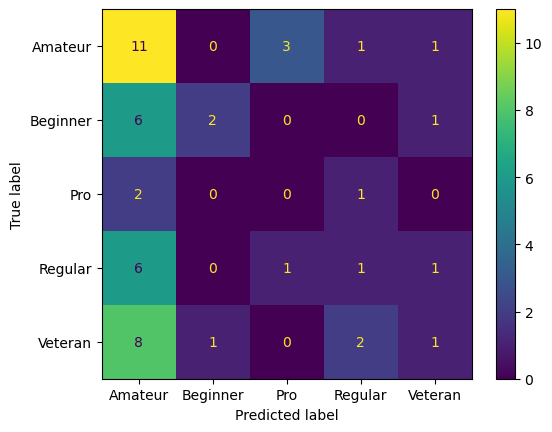

In [19]:
# Fit the pipeline on the training set
players_tune_pipe.fit(X_train, y_train)

# Generate and display the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    players_tune_pipe,  # We are directly passing the pipeline and let sklearn do the predictions for us
    X_test,
    y_test
)

**Figure 5: Confusion matrix showing the performance of the classification model (model 1), with true labels and predicted labels**

### Model 2

Since Model 1 achieved a moderately low accuracy of **34.7%**, there is potential to improve the model's performance by incorporating additional features through **feature engineering**. One possible enhancement is adding squared age as a new predictor variable. This transformation could capture non-linear relationships between age and experience level, which may not be fully addressed by the original age and played_hours variables. 

##### The rest of the steps, including standardizing the predictors and tuning, will follow the same process as above, in Model 1, but with the new feature incorporated into the model. 

In [20]:
# Preprocessor Setup
players_preprocessor2 = make_column_transformer(
    (StandardScaler(), ["age", "squared_age", "played_hours"]),
    verbose_feature_names_out=False
)

In [21]:
# create X_train and y_train; X_test and y_test
X_train2 = players_train[["age", "squared_age", "played_hours"]]
y_train2 = players_train["experience"]

X_test2 = players_test[["age", "squared_age", "played_hours"]]
y_test2 = players_test["experience"]

# Create a pipeline with preprocessing and KNN classifier
players_tune_pipe2 = make_pipeline(players_preprocessor2, knn)

# Initialize GridSearchCV for cross validation 
players_tune_grid2 = GridSearchCV(
    estimator=players_tune_pipe2,         # Pipeline  
    param_grid=param_grid,               # Parameter grid for tuning
    cv=5                                 # 5-fold cross-validation
)

# Fit the GridSearchCV model to the training data
players_tune_grid2.fit(X_train2, y_train2)

# Store the cross-validation results in a DataFrame for analysis
accuracies_grid2 = pd.DataFrame(players_tune_grid2.cv_results_)

# Select relevant columns and rename them for clarity
accuracies_grid2 = (
    accuracies_grid2[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score"
    ]]
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
)

/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


#### Identifying the Best K Value
We created a line plot to visualize the relationship between the number of neighbors (n_neighbors) and the corresponding accuracy estimates (mean_test_score). Similarly to our analysis for Model 1, accuracy peaks at 41, meaning this is the best performing K value. Using the results from the GridSearchCV, the best-performing K value was confirmed to be K = 41, which yielded the highest accuracy based on cross-validation.

In [22]:
# Create a line plot to visualize the accuracy vs. number of neighbors
accuracy_vs_k2 = alt.Chart(accuracies_grid2).mark_line(point=True).encode(
    x=alt.X("n_neighbors").title("Neighbors"),
    y=alt.Y("mean_test_score")
        .scale(zero=False)
        .title("Accuracy estimate")
).properties(
    title="Neighbors vs. Accuracy Estimate"
)

accuracy_vs_k2

alt.Chart(...)

**Figure 6: Line Plot comparing the accuracy estimate vs the number of neighbors**

In [23]:
# Display the best parameter (K = 41)
players_tune_grid2.best_params_

{'kneighborsclassifier__n_neighbors': 41}

In [24]:
players_test["predicted"] = players_tune_grid2.predict(
    players_test[["age", "squared_age", "played_hours"]]
)

players_test.head()

,played_hours,age,squared_age,log_age,sin_age,experience,predicted
104,0.0,26,676,3.258097,0.762558,Amateur,Amateur
44,2.2,24,576,3.178054,-0.905578,Veteran,Amateur
100,0.0,20,400,2.995732,0.912945,Amateur,Veteran
121,0.1,24,576,3.178054,-0.905578,Beginner,Amateur
49,0.4,22,484,3.091042,-0.008851,Beginner,Amateur


#### Evaluating Model Accuracy on the Test Set 

The accuracy of the model was tested on the test data. Suprisingly, Model 2 achieved an accuracy of approximately 34.7%, which is the same as **Model 1**

In [25]:
# Evaluate the model's accuracy on the test set
players_prediction_accuracy2 = players_tune_grid2.score(X_test2, y_test2)

players_prediction_accuracy2

0.3469387755102041

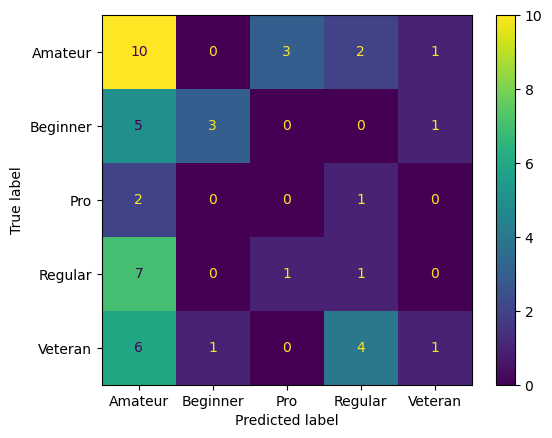

In [26]:
# Fit the pipeline on the training set
players_tune_pipe2.fit(X_train2, y_train2)

# Generate and display the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    players_tune_pipe2,  # We are directly passing the pipeline and let sklearn do the predictions for us
    X_test2,
    y_test2
)

**Figure 7: Confusion matrix showing the performance of the classification model (model 2), with true labels and predicted labels**

### Model 3

It seems like Model 2, despite incorporating an additional feature (squared age), did not improve the accuracy. As a next step, we will add another predictor, sin_age, to the model. The updated model will follow the same steps as before, including data preprocessing, standardization, and hyperparameter tuning, but with the new sin_age feature incorporated

In [27]:
# Preprocessor Setup
players_preprocessor3 = make_column_transformer(
    (StandardScaler(), ["age", "squared_age", "sin_age", "played_hours"]),
)

In [28]:
# create X_train and y_train; X_test and y_test
X_train3 = players_train[["age", "squared_age", "sin_age", "played_hours"]]
y_train3 = players_train["experience"]

X_test3 = players_test[["age", "squared_age", "sin_age", "played_hours"]]
y_test3 = players_test["experience"]

# Create a pipeline with preprocessing and KNN classifier
players_tune_pipe3 = make_pipeline(players_preprocessor3, knn)

# Initialize GridSearchCV for cross validation 
players_tune_grid3 = GridSearchCV(
    estimator=players_tune_pipe3,         # Pipeline  
    param_grid=param_grid,               # Parameter grid for tuning
    cv=5                                 # 5-fold cross-validation
)

# Fit the GridSearchCV model to the training data
players_tune_grid3.fit(X_train3, y_train3)

# Store the cross-validation results in a DataFrame for analysis
accuracies_grid3 = pd.DataFrame(players_tune_grid3.cv_results_)

# Select relevant columns and rename them for clarity
accuracies_grid3 = (
    accuracies_grid3[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score"
    ]]
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
)

/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


#### Identifying the Best K Value
We created a line plot to visualize the relationship between the number of neighbors (n_neighbors) and the corresponding accuracy estimates (mean_test_score). The accuracy peaks at 2, meaning this is the best performing K value. Using the results from the GridSearchCV, the best-performing K value was confirmed to be K = 2, which yielded the highest accuracy based on cross-validation.

In [29]:
# Create a line plot to visualize the accuracy vs. number of neighbors
accuracy_vs_k3 = alt.Chart(accuracies_grid3).mark_line(point=True).encode(
    x=alt.X("n_neighbors").title("Neighbors"),
    y=alt.Y("mean_test_score")
        .scale(zero=False)
        .title("Accuracy estimate")
).properties(
    title="Neighbors vs. Accuracy Estimate"
)

accuracy_vs_k3

alt.Chart(...)

**Figure 8: Line Plot showing the accuracy estimate vs the number of neighbors**

In [30]:
# Display the best parameter (K = 2)
players_tune_grid3.best_params_

{'kneighborsclassifier__n_neighbors': 2}

In [31]:
players_test["predicted"] = players_tune_grid3.predict(
    players_test[["age", "squared_age", "sin_age", "played_hours"]]
)

players_test.head()

,played_hours,age,squared_age,log_age,sin_age,experience,predicted
104,0.0,26,676,3.258097,0.762558,Amateur,Amateur
44,2.2,24,576,3.178054,-0.905578,Veteran,Amateur
100,0.0,20,400,2.995732,0.912945,Amateur,Amateur
121,0.1,24,576,3.178054,-0.905578,Beginner,Beginner
49,0.4,22,484,3.091042,-0.008851,Beginner,Amateur


#### Evaluating Model Accuracy on the Test Set 

The accuracy of the model was tested on the test data. Model 3 achieved an accuracy of approximately 28.6%, which is lower than both Model 1 and Model 2

In [32]:
# Evaluate the model's accuracy on the test set
players_prediction_accuracy3 = players_tune_grid3.score(X_test3, y_test3)

players_prediction_accuracy3

0.2857142857142857

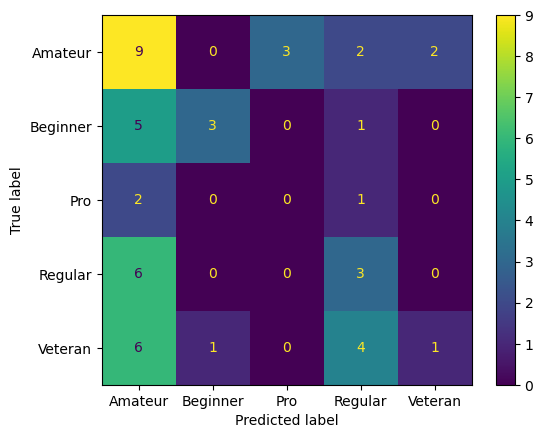

In [33]:
# Fit the pipeline on the training set
players_tune_pipe3.fit(X_train3, y_train3)

# Generate and display the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    players_tune_pipe3,  # We are directly passing the pipeline and let sklearn do the predictions for us
    X_test3,
    y_test3
)

**Figure 9: Confusion matrix showing the performance of the classification model (model 3), with true labels and predicted labels**

### Model 4

It seems like Model 3, despite incorporating an additional feature (sin_age), did not improve the accuracy, but instead decreased accuracy. As our final model, we will add one final predictor, log_age, to the model. The updated model will follow the same steps as before, including data preprocessing, standardization, and hyperparameter tuning, but with the new log_age feature incorporated

In [34]:
# Preprocessor Setup
players_preprocessor4 = make_column_transformer(
    (StandardScaler(), ["age", "squared_age", "sin_age", "log_age", "played_hours"]),
)

# check if data is scaled
players_scaled4 = players_preprocessor4.fit_transform(players_train)
players_scaled4.head()

,standardscaler__age,standardscaler__squared_age,standardscaler__sin_age,standardscaler__log_age,standardscaler__played_hours
99,-1.035241,-0.465698,-0.304809,-1.794907,-0.152896
86,0.173412,-0.014895,-0.719107,0.418631,-0.184696
32,-0.485853,-0.295915,-0.873211,-0.609840,-0.184696
20,-1.474751,-0.559371,1.736841,-3.174448,-0.165616
111,-0.046343,-0.117936,1.532529,0.109111,0.069699


In [35]:
# create X_train and y_train; X_test and y_test
X_train4 = players_train[["age", "squared_age", "sin_age", "log_age", "played_hours"]]
y_train4 = players_train["experience"]

X_test4 = players_test[["age", "squared_age", "sin_age", "log_age", "played_hours"]]
y_test4 = players_test["experience"]

# Create a pipeline with preprocessing and KNN classifier
players_tune_pipe4 = make_pipeline(players_preprocessor4, knn)

# Initialize GridSearchCV for cross validation 
players_tune_grid4 = GridSearchCV(
    estimator=players_tune_pipe4,         # Pipeline  
    param_grid=param_grid,               # Parameter grid for tuning
    cv=5                                 # 5-fold cross-validation
)

# Fit the GridSearchCV model to the training data
players_tune_grid4.fit(X_train4, y_train4)

# Store the cross-validation results in a DataFrame for analysis
accuracies_grid4 = pd.DataFrame(players_tune_grid4.cv_results_)

# Select relevant columns and rename them for clarity
accuracies_grid4 = (
    accuracies_grid4[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score"
    ]]
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
)

accuracies_grid4.head()

/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,n_neighbors,mean_test_score
0,1,0.272644
1,2,0.320690
2,3,0.292874
3,4,0.252414
4,5,0.265977


#### Identifying the Best K Value
We created a line plot to visualize the relationship between the number of neighbors (n_neighbors) and the corresponding accuracy estimates (mean_test_score). The accuracy peaks at 9, meaning this is the best performing K value. Using the results from the GridSearchCV, the best-performing K value was confirmed to be K = 9, which yielded the highest accuracy based on cross-validation.

In [36]:
# Create a line plot to visualize the accuracy vs. number of neighbors
accuracy_vs_k4 = alt.Chart(accuracies_grid4).mark_line(point=True).encode(
    x=alt.X("n_neighbors").title("Neighbors"),
    y=alt.Y("mean_test_score")
        .scale(zero=False)
        .title("Accuracy estimate")
).properties(
    title="Neighbors vs. Accuracy Estimate"
)

accuracy_vs_k4

alt.Chart(...)

**Figure 10: Line Plot showing the accuracy estimate vs the number of neighbors**

In [37]:
# Display the best parameter (K = 9)
players_tune_grid4.best_params_

{'kneighborsclassifier__n_neighbors': 9}

In [38]:
players_test["predicted"] = players_tune_grid4.predict(
    players_test[["age", "squared_age", "sin_age", "log_age", "played_hours"]]
)

players_test.head()

,played_hours,age,squared_age,log_age,sin_age,experience,predicted
104,0.0,26,676,3.258097,0.762558,Amateur,Amateur
44,2.2,24,576,3.178054,-0.905578,Veteran,Amateur
100,0.0,20,400,2.995732,0.912945,Amateur,Regular
121,0.1,24,576,3.178054,-0.905578,Beginner,Amateur
49,0.4,22,484,3.091042,-0.008851,Beginner,Amateur


#### Evaluating Model Accuracy on the Test Set 

The accuracy of the model was tested on the test data. Model 4 achieved an accuracy of approximately 28.6%, which is the same as Model 3

In [39]:
# Evaluate the model's accuracy on the test set
players_prediction_accuracy4 = players_tune_grid4.score(X_test4, y_test4)

players_prediction_accuracy4

0.2857142857142857

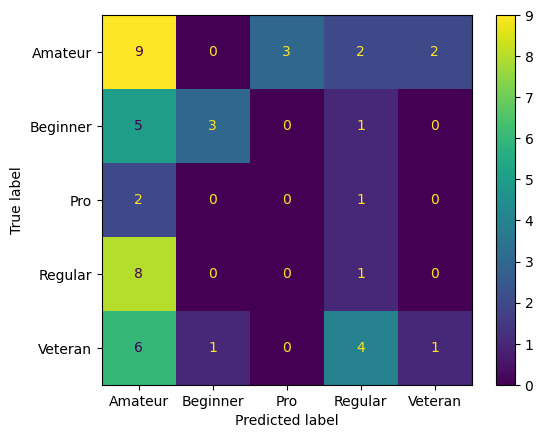

In [40]:
# Fit the pipeline on the training set
players_tune_pipe4.fit(X_train4, y_train4)

# Generate and display the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    players_tune_pipe4,  # We are directly passing the pipeline and let sklearn do the predictions for us
    X_test4,
    y_test4
)

**Figure 11: Confusion matrix showing the performance of the classification model (model), with true labels and predicted labels**

### Choosing the Best Model

After evaluating the performance of multiple models, we compiled the accuracy scores for each model into a DataFrame:

In [41]:
combined_accuracy = pd.DataFrame({
    "model number": [1, 2, 3, 4], 
    "accuracy score": [0.35, 0.35, 0.29, 0.29]})

combined_accuracy

,model number,accuracy score
0,1,0.35
1,2,0.35
2,3,0.29
3,4,0.29


Given that Model 1 and Model 2 have the same accuracy of **0.35**, but Model 1 uses the original predictor variables without any feature engineering, we will select **Model 1** as the 'best' model. This decision is based on the fact that Model 1 maintains simplicity by relying on the original variables, making it more interpretable. 

### Testing the Model 1

We tested Model 1 using age and played_hours for four different age groups: child, teen, adult, and senior. The following test data was used for each group:

+ Children (Age 10)
+ Teens (Age 19)
+ Adults (Age 35)
+ Seniors (Age 65)
  
The model was used to predict the experience level for each set of participants based on the number of played_hours. The predictions for each group are as shown below: 

In [42]:
test_data_child = pd.DataFrame({
    "age": [10,10,10,10,10], 
    "played_hours": [0, 5, 10, 25, 50],  
})


test_data_teen = pd.DataFrame({
    "age": [19, 19, 19, 19, 19], 
    "played_hours": [0, 5, 10, 25, 50],  
})


test_data_adult = pd.DataFrame({
    "age": [35, 35, 35, 35, 35], 
    "played_hours": [0, 5, 10, 25, 50],  
})

test_data_senior = pd.DataFrame({
    "age": [65, 65, 65, 65, 65], 
    "played_hours": [0, 5, 10, 25, 50],  
})


# Predict experience level 

print(players_tune_grid.predict(test_data_child))
print(players_tune_grid.predict(test_data_teen))
print(players_tune_grid.predict(test_data_adult))
print(players_tune_grid.predict(test_data_senior))


['Amateur' 'Amateur' 'Amateur' 'Amateur' 'Amateur']
['Veteran' 'Veteran' 'Veteran' 'Amateur' 'Amateur']
['Amateur' 'Amateur' 'Amateur' 'Amateur' 'Amateur']
['Amateur' 'Amateur' 'Amateur' 'Amateur' 'Amateur']


For most age groups, the majority of our 'test participants' are classified as Amateur, indicating that the 'Amateur' experience level is dominant in the dataset (i.e. contrubutes most to our data).

### RESULTS

To determine which types of players are most likely to contribute the most gameplay data to our game, our team developed a KNN model. For the first model, we used a train-test split of 75% training data and 25% testing data. We scaled our predictor variables to ensure they contributed equally to the distance metric and used a parameter grid for k values ranging from 1 to 100. Applying 5-fold cross-validation, we found that the optimal k value for the first model was k = 41, which gave us an accuracy of 35%. To evaluate model performance, we created a confusion matrix in Figure 5, which showed that the model most accurately predicted 11 players as amateurs, 6 players as beginners, 2 players as pros, 6 players as regulars, and 8 players as veterans. This aligns with our exploratory analysis that indicated amateurs made up the majority of the dataset. Despite this, we considered the 35% accuracy too low and wanted to improve the model. To enhance our model, we applied feature engineering to the age variable, creating three additional predictors the square, sine, and log of age. These new variables were incorporated into Models 2, 3, and 4, by employing the same steps as model 1. Model 2 returned an accuracy of 35%, identical to the original model, while Models 3 and 4 performed worse, with accuracies of 29% each. The confusion matrices for all four models Figures 5, 7, 9, and 11, consistently showed that amateurs were the most accurately predicted class across all models.

### Discussion

To determine which types of players are most likely to contribute the most gameplay data to PLAICraft, our team developed a KNN classification model. We used age and playing hours as predictor variables to classify players based on their experience level, specifically asking the question, “What is a player’s experience level based on their age and the time they spend playing the game?” Our initial model achieved an accuracy of 35%. This was considered low, as our majority class classifier would give us an accuracy of 32%, meaning there is only a 3% difference. To try and improve this result, we applied feature engineering to the age variable by creating three more predictors: the square, sine, and log of age. However, the results did not improve: the second model achieved the same accuracy as the original 35%, while the third and fourth models performed worse, both with accuracies of 29%. Given these results, we decided to focus on the first model, as it achieved the highest accuracy without requiring additional feature engineering. 


Looking at the confusion matrix (Figure 5), amateurs were correctly classified 11 times, making it the most accurately predicted class in the dataset. Furthermore, by creating 20 new observations and running them through our model, we observed that the model classified 17 out of 20 test players as amateurs. **Therefore, this classification dominance demonstrates that players with an amateur experience level are the most likely to contribute the majority of gameplay data, answering our initial question.** 

This result was expected based on our exploratory data analysis. From our exploratory data analysis, Figure 3 reveals that the proportion of amateurs had been playing the game compared to players at other experience levels. Furthermore, we found that 32% of the players in the dataset were classified as amateurs. This imbalance in the class variable suggests that our models are more likely to predict the amateur class, as there is more data available for it. As a result, it is not surprising that we found amateurs to be the most frequently and accurately predicted class, as the dataset contains more amateurs, meaning that amateurs contribute the most to the data. In a real-world setting, this is likely explained by the fact that amateur players, being in the middle of the experience spectrum, might spend the most time in the game. They could be refining their skills and often engage in various game activities, leading to more gameplay data compared to players at either end of the experience scale.

In conclusion, we recommend that the PLAICraft team focus their recruitment efforts on amateur players. Given their higher representation in the dataset and the fact that they contribute the most gameplay data, targeting this group could help PLAICraft gather more valuable insights for their research. By focusing on amateurs, PLAICraft can refine gameplay features that resonate with this key demographic, potentially enhancing player engagement and retention. Since amateurs are in the middle of the experience spectrum, their behavior may reflect a balance between exploration and skill development, providing valuable insights into how players progress through the game.


### LIMITATIONS


However, the PLAICraft team should carefully consider the limitations of our analysis. First, there was significant class imbalance within the dataset, which might have contributed to the low accuracy we observed. To address this issue, our group considered oversampling the rare classes in our dataset to balance the class distribution. However, we decided against rebalancing the experience levels, as this would alter our given data, resulting in us losing sight of our initial research question. Oversampling the rare experience classes would have inflated their representation, meaning we would no longer have a clear indicator as to which experience level contributes the most gameplay data. Another significant limitation of our analysis is the size of the dataset, we only had 196 data points, which may not be sufficient to uncover meaningful patterns or train a well-performing model. 
Additionally, the dataset provided, players.csv, appears to be based on a survey that players completed before starting the game. This means that players could self-identify their experience level, which introduces potential inaccuracies. For example, a player with zero playing hours could identify themselves as a "veteran." Using the same rationale, the reported age may also be unreliable, as players often provide fake ages on gaming platforms. 


### FUTURE DIRECTIONS

This analysis opens up several avenues for further research and exploration. First, to address the limitations regarding accuracy and dataset size, we might ask: How can we improve the accuracy of predicting player experience levels? Additionally, now knowing that amateur players contribute the most gameplay data, we can ask: What specific factors drive amateur players to contribute the most gameplay data?  Investigating this could help refine game mechanics to further incentivize gameplay and data contribution across all experience levels, ensuring that insights are not overly reliant on a single group. 


### REFERENCES

Smith, A. (2024, October 30). *plaicraft.ai launch*. Pacific Laboratory for Artificial Intelligence. [https://plai.cs.ubc.ca/2023/09/27/plaicraft/](https://plai.cs.ubc.ca/2023/09/27/plaicraft/)